# Dataset Overview:
- Stations: The dataset includes weather data from multiple stations.
- Columns: There are 15 columns in the dataset, representing different weather variables.
- Rows: Each row represents weather data for a specific station, date, and time.
- Stations: There are 5 weather stations included in the dataset.
- Time Period: The dataset covers a span of 5 years.
- Temporal Granularity: There are 4 rows per day, representing 4 different hours.

- In total, 37 stations were initially considered. However, based on the volume of relevant column data,
5 stations were selected. The stations selected for this project are:

1. Alon Shvut
2. Beer Sheva
3. Karmiel
4. Afula
5. Tel Aviv (TLV)

This selection was made after a brief investigation into the data. The goal was to optimize the data
used for this project by focusing on stations with the most extensive and relevant data available.

Estimated Total Rows (before cleaning): 15 * 5 * 4 * 365 * 5 = 547,500

In [1]:
import time
import traceback
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

from data_utils import DataUtils, DF_COLUMNS
from src.api_data_acquirer import APIDataAcquirer
from src.data_processor import DataProcessor
from src.logger import Logger
from src.web_scraper import WebScraper

## 01) Scrape Data using Selenium

The following handles the scraping phase, attempting to acquire stations data with retries.


In [2]:
data_utils = DataUtils()
web_scraper = None
logger = Logger()
retry_count = 50  # Number of retries
retry_delay = 5  # Delay between retries in seconds
# Create an empty DataFrame
df_columns = data_utils.load_data_params("DF_COLUMNS")
df = pd.DataFrame(columns=df_columns)

In [71]:
# DEMO
DataUtils.RAW_DATA_FULL_PATH = Path(DataUtils.RAW_DATA_PATH) / 'climate_air_quality_demo.csv'
DataUtils.PROCESSED_DATA_FULL_PATH = Path(DataUtils.PROCESSED_DATA_PATH) / 'climate_air_quality_proc_demo.csv'

In [11]:
while retry_count > 0:
    try:
        web_scraper = WebScraper(WebScraper.SCRAPE_URL, data_utils, df)
        logger.log(f"web_scraper.stations_elements {hex(id(web_scraper.stations_elements))}")
        web_scraper.open_menu()
        web_scraper.acquire_stations_data()
    except ValueError as value_error:
        #Failed to load stations from file
        logger.log('Quiting...')
        break
    except Exception as e:
        log_message = f"An exception occurred: {str(e)}"
        traceback_str = traceback.format_tb(e.__traceback__)
        log_message += f"\nTraceback:\n{traceback_str}"
        logger.log(log_message, logger.WARNING)
        traceback.print_tb(e.__traceback__)
        print('-' * 40)
        retry_count -= 1
        if web_scraper:
            web_scraper.driver.quit()
        if retry_count == 0:
            logger.log("Maximum retry attempts reached. Exiting...", logger.ERROR)
        else:
            logger.log(f"Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)

scrape website: https://air.sviva.gov.il 
ניטור אוויר בישראל
web_scraper.stations_elements 0x13a3d8e40
Opening menu...
38 stations found
5 selected stations
Selecting station: אלון שבות, גוש עציון
Selecting date 12/06/2023
Scraping אלון שבות, גוש עציון
10 columns found for station.
Finished with אלון שבות, גוש עציון station 
Saving... אלון שבות, גוש עציון 12/06/2023
Selecting station: אלון שבות, גוש עציון
Total 40 fetched data [rXc] for אלון שבות, גוש עציון station
Selecting station: באר שבע, שכונה ו
Selecting date 12/06/2023
Scraping באר שבע, שכונה ו
10 columns found for station.
Finished with באר שבע, שכונה ו station 
Saving... באר שבע, שכונה ו 12/06/2023
Selecting station: באר שבע, שכונה ו
Total 40 fetched data [rXc] for באר שבע, שכונה ו station
Selecting station: כרמיאל, גליל מערבי
Selecting date 12/06/2023
Scraping כרמיאל, גליל מערבי
11 columns found for station.
Finished with כרמיאל, גליל מערבי station 
Saving... כרמיאל, גליל מערבי 12/06/2023
Selecting station: כרמיאל, גליל מערבי

  File "/var/folders/p8/b79r5p8j73dd3zpxs29shwpw0000gn/T/ipykernel_11068/2948020523.py", line 3, in <module>
    web_scraper = WebScraper(WebScraper.SCRAPE_URL, data_utils, df)
  File "/Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/src/web_scraper.py", line 71, in __init__
    logger.log(f"scrape website: {self.url} \n{self.driver.title}")
  File "/Users/deni/IdeaProjects/Home Exercise/venv/lib/python3.9/site-packages/selenium/webdriver/remote/webdriver.py", line 460, in title
    return self.execute(Command.GET_TITLE).get("value", "")
  File "/Users/deni/IdeaProjects/Home Exercise/venv/lib/python3.9/site-packages/selenium/webdriver/remote/webdriver.py", line 440, in execute
    self.error_handler.check_response(response)
  File "/Users/deni/IdeaProjects/Home Exercise/venv/lib/python3.9/site-packages/selenium/webdriver/remote/errorhandler.py", line 245, in check_response
    raise exception_class(message, screen, stacktrace)


Retrying in 5 seconds...


KeyboardInterrupt: 

## 02) Fetching data using REST API

The code snippet above demonstrates a data acquisition process using an API.

- First, an instance of the `DataUtils` class is created to handle data-related utilities.
- The API key is loaded from the data parameters using the `load_data_params` method of the `DataUtils` instance.
- An instance of the `APIDataAcquirer` class is created, passing the API key and the `DataUtils` instance as parameters.
- A flag `fetch_all_data_res` is initialized as `False` to track if all data has been fetched.
- A `while` loop is used to repeatedly attempt to fetch all the data until successful.
- Inside the loop, the `fetch_all_data` method of the `APIDataAcquirer` instance is called.
- If an exception occurs during the data fetching process, it is caught, and a retry is attempted after a 5-second delay.
- The loop continues until all data is successfully fetched, at which point the `fetch_all_data_res` flag is set to `True`.

Note: The `logger` is used to log any errors or exception messages encountered during the process.



In [8]:
api_key = data_utils.load_data_params("API_KEY")
acquirer = APIDataAcquirer(api_key)
all_api_data_fetched = False

In [9]:
while not all_api_data_fetched:
    try:
        fetch_all_data_res = acquirer.fetch_all_data()
    except Exception as e:
        logger.log(f"Failed. Retrying... \n{e}", logger.ERROR)
        time.sleep(5)

13 stations are selected, starting to fetch...
TEL AVIV COAST [178] Station
Earliest Date March 2005
Got data for June 2023 0.281896s
Done with June 2023 for TEL AVIV COAST
No data for TEL AVIV COAST station in 2023-07-01 00:00:00 month 
No Content
Done with TEL AVIV COAST [5.440101861953735s]
TEL AVIV COAST_1m [299] Station
Earliest Date January 2009
Got data for June 2023 0.099534s
Done with June 2023 for TEL AVIV COAST_1m
No data for TEL AVIV COAST_1m station in 2023-07-01 00:00:00 month 
No Content
Done with TEL AVIV COAST_1m [1.9221131801605225s]
AFULA NIR HAEMEQ [16] Station
Earliest Date November 1994
Got data for June 2023 0.27749s
Done with June 2023 for AFULA NIR HAEMEQ
No data for AFULA NIR HAEMEQ station in 2023-07-01 00:00:00 month 
No Content
Done with AFULA NIR HAEMEQ [2.758477210998535s]
AFULA NIR HAEMEQ_1m [306] Station
Earliest Date January 2001
Got data for June 2023 35.107993s
Done with June 2023 for AFULA NIR HAEMEQ_1m
No data for AFULA NIR HAEMEQ_1m station in 202

KeyboardInterrupt: 

In [ ]:
def exploration(api_acquirer: APIDataAcquirer):
    if all_stations := api_acquirer.get_stations():
        short_stations = {station.get('stationId'): station.get('name') for station in all_stations.json()}
        inactive_stations = [s for s in all_stations.json() if not s.get('active')]
        ALON_SHVUT = {key:value for key, value in short_stations.items() if 'ALON' in value}
        BEER_SHEVA = {key:value for key, value in short_stations.items() if 'SHEVA' in value}
        KARMIEL = {key:value for key, value in short_stations.items() if 'KARMIEL' in value or 'CARMIEL' in value}
        AFULA = {key:value for key, value in short_stations.items() if 'AFULA' in value}
        TLV = {key:value for key, value in short_stations.items() if 'TEL AVIV' in value}
        alon_shvut_lat, alon_shvut_long = 31.654463, 35.125797
        alon_shvut = [{s.get('name'): s.get('location')} for s in all_stations.json() if s.get('location').get('latitude') and alon_shvut_lat*0.999 <= s.get('location').get('latitude') <= alon_shvut_lat*1.002 and alon_shvut_long*0.999 <= s.get('location').get('longitude') <= alon_shvut_long*1.001]
        # 'ROSH ZURIM' 1KM from Alon Shvut
        ALON_SHVUT = {key:value for key, value in short_stations.items() if 'ROSH ZURIM' in value}
        karmiel_lat, karmiel_long = 32.912439, 35.288695
        karmiel = [{s.get('name'): s.get('location')} for s in all_stations.json() if s.get('location').get('latitude') and karmiel_lat*0.999 <= s.get('location').get('latitude') <= karmiel_lat*1.005 and karmiel_long*0.999 <= s.get('location').get('longitude') <= karmiel_long*1.001]
        # 'ESHHAR' 2KM away from Karmiel
        KARMIEL = {key:value for key, value in short_stations.items() if 'ESHHAR' in value}

## 03) Process Data

Process the fetch data and save it to new processed csv file.


In [11]:
# NO DEMO
DataUtils.RAW_DATA_FULL_PATH = Path(DataUtils.RAW_DATA_PATH) / 'climate_air_quality.csv'
DataUtils.PROCESSED_DATA_FULL_PATH = Path(DataUtils.PROCESSED_DATA_PATH) / 'climate_air_quality_proc.csv'


In [12]:
LOG_LINE_SEPERATOR_LENGTH = logger.LOG_LINE_SEPERATOR_LENGTH
data_processor = DataProcessor(data_utils)
file_path = data_utils.RAW_DATA_FULL_PATH
output_path = data_utils.PROCESSED_DATA_FULL_PATH
# Load the weather data file into a pandas DataFrame
df = data_processor.data_utils.load_file_to_pandas(file_path)
processed_data = df.copy()

Path exists.


/Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/data_utils.py:83: DtypeWarning: Columns (4,5,6,7,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


CSV file loaded into pandas DataFrame successfully.


### Step 1: Convert Data Types

In [6]:
current_step = "Convert Data Types"
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH, current_step)
processed_data = data_processor.convert_data_types(processed_data)
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH)

-----------Convert Data Types-----------
Formatting date from %d/%m/%Y to %Y/%m/%d
Formatting time %H:%M
Sorting by ['Station', 'Date', 'Time']
Converting numeric cols ['Pressure', 'RH', 'Temp', 'WD', 'WS', 'PREC', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5']
----------------------------------------


### Step 2: Handle duplicates

In [7]:
current_step = "Removing Duplicates"
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH, current_step)
processed_data = data_processor.handle_duplicates(processed_data)
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH)

----------Removing Duplicates-----------
Data Frame before cleaning duplicates: (2259433, 15)
Removed 2219673 duplicate rows
Data Frame after cleaning duplicates: (39760, 15)
----------------------------------------


### Step 3: Handle missing values

In [8]:
current_step = "Missing Values"
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH, current_step)
processed_data = data_processor.handle_missing_values(processed_data)
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH)

-------------Missing Values-------------
Forward filling [2 days limit]:
Pressure: 280 values (31814 still left)
RH: 392 values (2499 still left)
Temp: 537 values (8706 still left)
WD: 254 values (1361 still left)
WS: 406 values (196 still left)
PREC: 1204 values (6320 still left)
NO: 1414 values (921 still left)
NO2: 1417 values (921 still left)
NOX: 1415 values (921 still left)
O3: 1067 values (343 still left)
PM10: 1288 values (1309 still left)
PM2.5: 308 values (32882 still left)
Dropped 0 rows with all columns missing values
Dropped 1004 rows with 3 or more columns missing values
Dropped 2 columns: ['Pressure', 'PM2.5'], having less than 70% self.modified_data_frame threshold
Data Frame before cleaning corrupted columns: (39760, 15), after (38756, 13)
----------------------------------------


### Step 4: Detect and Handle Outliers

In [9]:
current_step = "Detect and Handle Outliers"
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH, current_step)
processed_data = data_processor.detect_and_handle_outliers(processed_data)
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH)

-------Detect and Handle Outliers-------
Outliers for variable RH:
4        101.50
18       107.50
19       104.50
20       105.00
24       100.50
98       100.50
99       107.50
100      101.00
104      103.00
106      107.00
107      109.00
29641    101.00
29925    101.00
36209    100.05
Name: RH, dtype: float64
Outliers for variable NO:
0       -0.1
8       -0.1
9       -0.1
12      -0.1
15      -0.1
        ... 
31913   -0.1
32195   -0.1
32278   -0.1
32279   -0.2
32280   -0.1
Name: NO, Length: 188, dtype: float64
Outliers for variable NO2:
1470    -30.4
1471    -30.4
1472    -30.4
1473    -30.4
1474    -30.4
1475    -30.4
1476    -30.4
1477    -30.4
1478    -30.4
15940    -0.7
15976    -0.1
Name: NO2, dtype: float64
Outliers for variable NOX:
6288    -0.1
15940   -0.9
15976   -0.3
16004   -0.1
Name: NOX, dtype: float64
Outliers for variable PM10:
56      -9.1
174     -2.0
223     -3.7
288     -3.1
369     -1.0
        ... 
35046   -5.9
35385   -0.6
35429   -2.3
35614   -1.5
35716  

### Step 5: Aggregate and Normalize data (for selected columns)

In [10]:
current_step = "Normalize data"
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH, current_step)
processed_data = data_processor.normalize_features(df, [DF_COLUMNS.TIME.value, DF_COLUMNS.STATION.value])
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH)

-------------Normalize data-------------
Converting unique values for column Time
Time, old to new values: {'1:00': 1, '7:00': 2, '13:00': 3, '19:00': 4, '01:00': 5, '07:00': 6}
count    2.259433e+06
mean     4.233612e+00
std      1.309414e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      6.000000e+00
Name: Time, dtype: float64
Converting unique values for column Station
Station, old to new values: {'אלון שבות, גוש עציון': 1, 'באר שבע, שכונה ו': 2, 'כרמיאל, גליל מערבי': 3, 'עפולה, עפולה': 4, 'תל אביב-יפו, אוניברסיטה': 5}
count    2.259433e+06
mean     2.552182e+00
std      1.101305e+00
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      5.000000e+00
Name: Station, dtype: float64
----------------------------------------


### Step 6: Saving

In [17]:
current_step = "Saving"
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH, current_step)
processed_data = processed_data.dropna()
data_processor.data_utils.save_to_file(output_path, processed_data, 'w')  # TODO Check
logger.log_separator_line(LOG_LINE_SEPERATOR_LENGTH)

-----------------Saving-----------------
----------------------------------------


# Exploratory Data Analysis (EDA)

After loading the data, performing several preprocessing steps, including handling missing values and outliers. Following this, implementing feature engineering, extracting date and time components from timestamps, and performing log transformation on select columns. Afterward, identifying and merge highly correlated columns. Lastly, creating visualization to understand the relationships between weather variables and air quality indicators.

In [16]:
data = data_utils.load_file_to_pandas(data_utils.PROCESSED_DATA_FULL_PATH)
# Column names representing various air quality and weather metrics
AIR_QUALITY_WEATHER_COLUMNS = [DF_COLUMNS.RH.value, DF_COLUMNS.TEMP.value, DF_COLUMNS.WD.value, DF_COLUMNS.WS.value,
                               DF_COLUMNS.PREC.value, DF_COLUMNS.NO.value, DF_COLUMNS.NO2.value, DF_COLUMNS.NOX.value,
                               DF_COLUMNS.O3.value, DF_COLUMNS.PM10.value]
FIGURES_PATH = data_utils.PROJECT_ROOT / 'reports/figures/'

class ADDED_COLUMNS:
    YEAR = 'Year'
    MONTH = 'Month'
    DAY = 'Day'
    DAY_OF_WEEK = 'DayOfWeek'
    TIME_1 = 'Time_1'
    TIME_2 = 'Time_2'
    TIME_3 = 'Time_3'
    TIME_4 = 'Time_4'

Path exists.
CSV file loaded into pandas DataFrame successfully.


In [17]:
def apply_log_transform(data_frame, columns_to_transform):
    logger.log(f"Applying logarithmic transformation to columns in the DataFrame.")
    modified_data_frame = data_frame.copy()
    for column in columns_to_transform:
        modified_data_frame[column] = np.log1p(modified_data_frame[column])
    logger.log(f"Log transformation applied to columns: {columns_to_transform}")
    return modified_data_frame

## Merging Correlated DataFrame Columns

The function `merge_correlation(data_frame, columns_of_interest, threshold)` merges columns in a DataFrame that have a correlation greater than a specified threshold.

It works as follows:

- Calculates a correlation matrix for the columns specified in `columns_of_interest`.
- Iterates through the correlation matrix, and for each pair of columns with a correlation above the given `threshold`, merges them by taking their average.
- Replaces one of the columns with this merged column and drops the other.

In [18]:
def merge_correlation(data_frame: pd.DataFrame, columns_of_interest: list, threshold: float = 0.7):
    logger.log(f"Iterate through the correlation matrix and merge correlated columns")
    modified_data_frame = data_frame.copy()
    # Compute the correlation matrix
    correlation_matrix = modified_data_frame[columns_of_interest].corr()

    for i in range(len(columns_of_interest)):
        for j in range(i + 1, len(columns_of_interest)):
            if (columns_of_interest[i] in modified_data_frame.columns) and (columns_of_interest[j] in modified_data_frame.columns):
                if abs(correlation_matrix.iloc[i, j]) > threshold:
                    merged_column = (modified_data_frame[columns_of_interest[i]] + modified_data_frame[columns_of_interest[j]]) / 2
                    modified_data_frame[columns_of_interest[i]] = merged_column
                    logger.log(f"merged {columns_of_interest[i]}")
                    modified_data_frame = modified_data_frame.drop(columns_of_interest[j], axis=1)
                    logger.log(f"drop {columns_of_interest[j]}")
    return modified_data_frame

## Extracting Date Components from DataFrame

The function `extract_date_components(data_frame)` adds new columns to a DataFrame representing different components of a date, specifically the year, month, day, and day of the week.

This is how it works:

- Extracts the year, month, and day from the `Date` column and creates new respective columns `Year`, `Month`, and `Day` in the DataFrame.
- Extracts the day of the week from the `Date` column, with Monday as 0 and Sunday as 6, and creates a new `DayOfWeek` column in the DataFrame.

In [19]:
def extract_date_components(data_frame: pd.DataFrame):
    logger.log(f"Create new columns for year, month, and day")
    modified_data_frame = data_frame.copy()

    modified_data_frame['Date'] = pd.to_datetime(modified_data_frame['Date'])
    modified_data_frame['Year'] = modified_data_frame['Date'].dt.year
    modified_data_frame['Month'] = modified_data_frame['Date'].dt.month
    modified_data_frame['Day'] = modified_data_frame['Date'].dt.day

    logger.log(f"Create new columns for day of the week (0=Monday, 6=Sunday)")
    modified_data_frame['DayOfWeek'] = modified_data_frame['Date'].dt.dayofweek

    return modified_data_frame


## Converting Time Column into Binary Columns

The function `binarize_time_column(data_frame)` transforms the categorical `Time` column in a DataFrame into multiple binary columns, one for each time category.

Here's the process:

- The `Time` column in the input DataFrame is considered categorical, with possible values from 0 to 3.
- For each unique value in the `Time` column, a new binary column is created using the `get_dummies` function. The new columns are prefixed with 'Time'.

In [20]:
def binarize_time_column(data_frame: pd.DataFrame):
    logger.log(f"Create new binary columns for each time variable in the original column")
    modified_data_frame = data_frame.copy()
    modified_data_frame = pd.get_dummies(modified_data_frame, columns=['Time'], prefix='Time')

    return modified_data_frame

## Transforming and Preprocessing Data

This code snippet outlines the major transformations applied to a data frame to prepare it for further analysis or modeling.

1. **Logarithmic Transformation:**
   This transformation helps in dealing with skewed data for improved model performance. The transformation is applied to certain columns (`NO`, `NO2`, `NOX`, `O3`, `PM10`) in the data frame.

2. **Merging Correlated Features:**
   The function `merge_correlation` is used to consolidate highly correlated columns in the data frame. This can help reduce redundancy in the dataset and can improve model training times and potentially model performance.

3. **Splitting Date and Time Columns:**
   The date components (year, month, and day) are extracted from the `Date` column and stored as new columns in the data frame.

4. **Binarizing Time Column:**
   The `Time` column is converted into binary format using the `binarize_time_column` function. This transformation turns the categorical `Time` column into multiple binary columns.

In [21]:
modified_data_frame = data.copy()
# Apply logarithmic transformation
modified_data_frame = apply_log_transform(modified_data_frame, [
    DF_COLUMNS.NOX.value,
    DF_COLUMNS.NO.value,
    DF_COLUMNS.NO2.value,
    DF_COLUMNS.O3.value,
    DF_COLUMNS.PM10.value,
])

# Merge Correlation
merge_correlation(modified_data_frame, AIR_QUALITY_WEATHER_COLUMNS)

# Convert (Split) Date and Time columns
modified_data_frame = extract_date_components(modified_data_frame)
modified_data_frame = binarize_time_column(modified_data_frame)

Applying logarithmic transformation to columns in the DataFrame.
Log transformation applied to columns: ['NOX', 'NO', 'NO2', 'O3', 'PM10']
Iterate through the correlation matrix and merge correlated columns
merged NO
drop NOX
Create new columns for year, month, and day
Create new columns for day of the week (0=Monday, 6=Sunday)
Create new binary columns for each time variable in the original column


In [22]:
data_utils.save_to_file(data_utils.PROCESSED_DATA_PATH / 'climate_air_quality_eda.csv' , modified_data_frame)

In [23]:
def print_info(data_frame: pd.DataFrame, columns: list):
    pd.set_option('display.max_columns', None)  # None means unlimited
    pd.set_option('display.max_rows', None)  # None means unlimited

    logger.log(data.describe())

    logger.log(f"NO: {data[DF_COLUMNS.NO.value].hist()}")
    logger.log(f"NO2: {data[DF_COLUMNS.NO2.value].hist()}")
    logger.log(f"NOX: {data[DF_COLUMNS.NOX.value].hist()}")
    logger.log(f"O3: {data[DF_COLUMNS.O3.value].hist()}")
    logger.log(f"PM10: {data[DF_COLUMNS.PM10.value].hist()}")

    logger.log(data_frame[columns].corr())

In [24]:
def create_outlier_scatter_plots(data_frame: pd.DataFrame, columns: list, path: Path):
    numeric_cols = data_frame[columns].select_dtypes(include=np.number).columns.tolist()
    z_scores = zscore(data_frame[numeric_cols])
    outliers = data_frame[np.abs(z_scores) > 3]
    for column in numeric_cols:
        plt.scatter(data_frame[column], data_frame[column], c='blue', label='Data')
        plt.scatter(outliers[column], outliers[column], c='red', label='Outliers')
        plt.xlabel(column)
        plt.ylabel(column)
        plt.title(f"Outliers in {column}")
        plt.legend()
        # plt.savefig(f"{path}/{column}_outliers.png")
        savefig_path = Path(path) / f"{column}_outliers.png"
        plt.savefig(f"{path}/{column}_outliers.png")
        logger.log(f"saving {path}/outlier_scatter_plots/{column}_outliers.png")
        plt.show()

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/RH_outliers.png


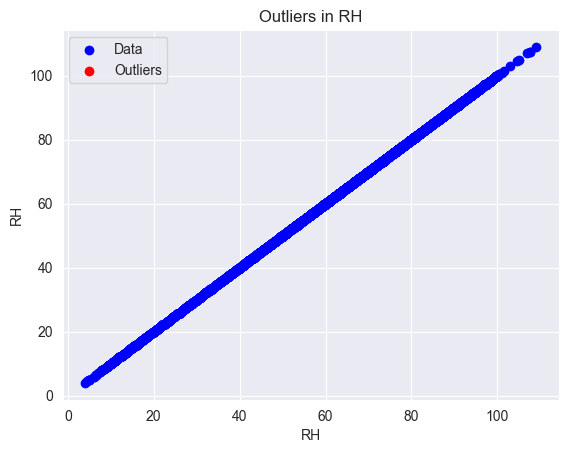

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/Temp_outliers.png


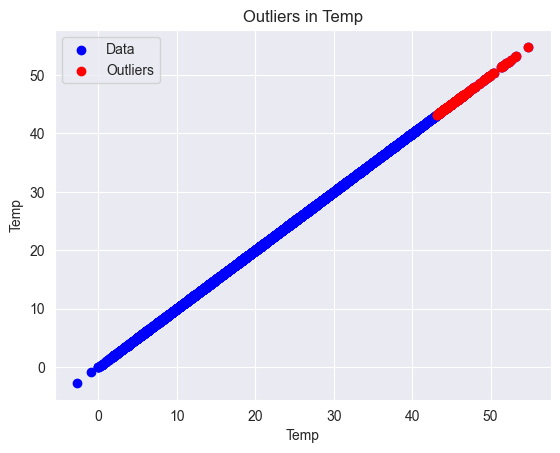

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/WD_outliers.png


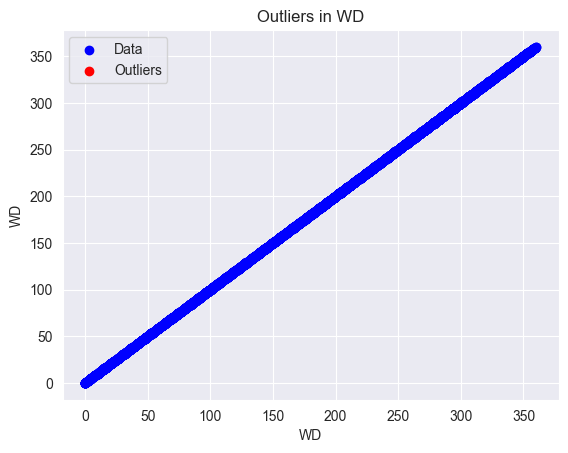

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/WS_outliers.png


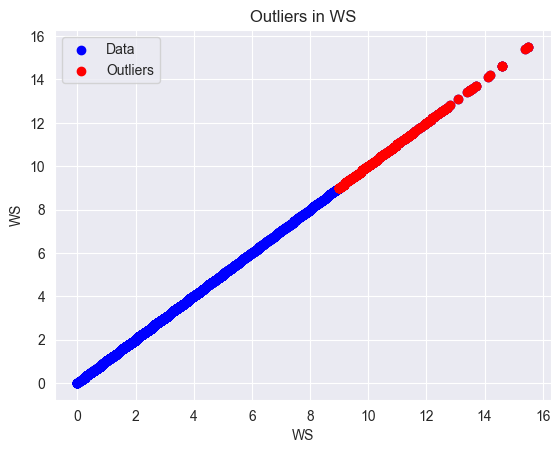

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/PREC_outliers.png


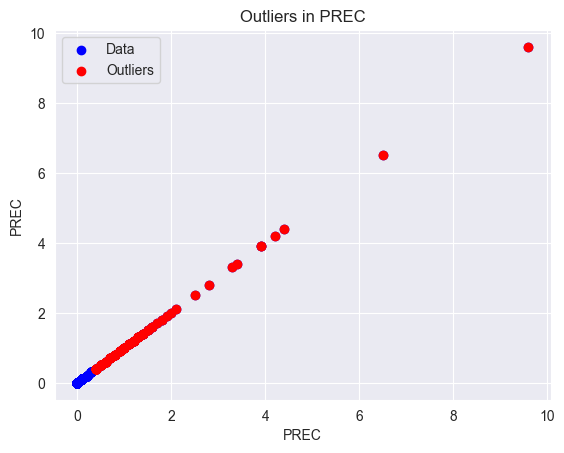

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/NO_outliers.png


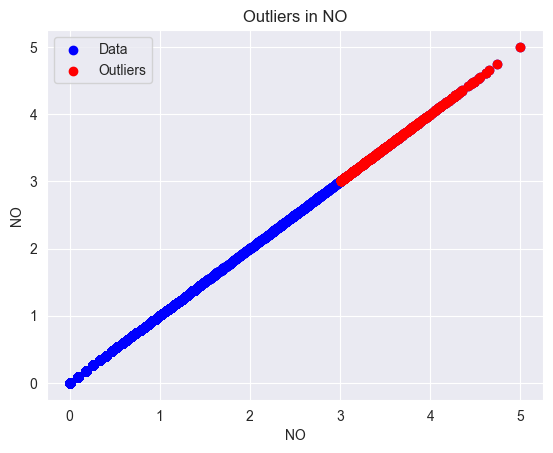

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/NO2_outliers.png


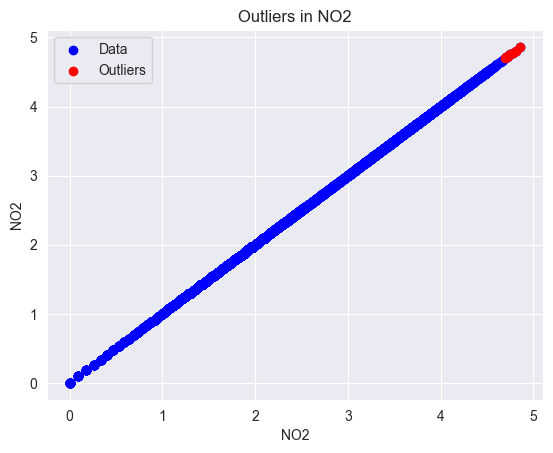

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/NOX_outliers.png


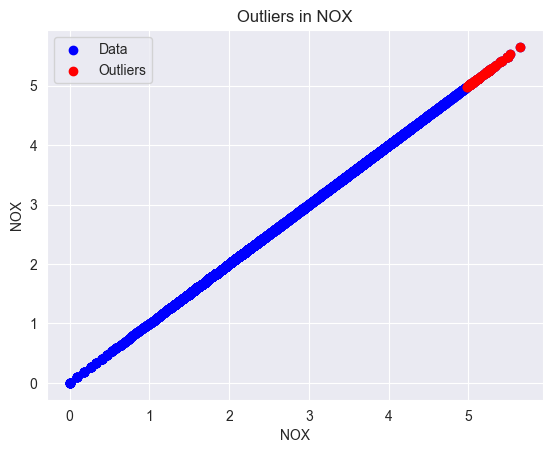

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/O3_outliers.png


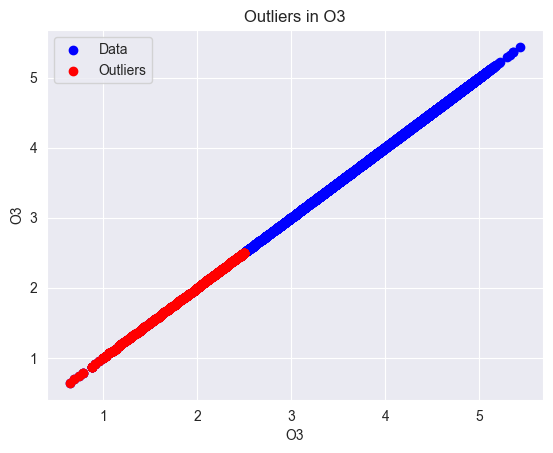

saving /Users/deni/IdeaProjects/ClimateAirQualityAnalyzer/reports/figures/outlier_scatter_plots/PM10_outliers.png


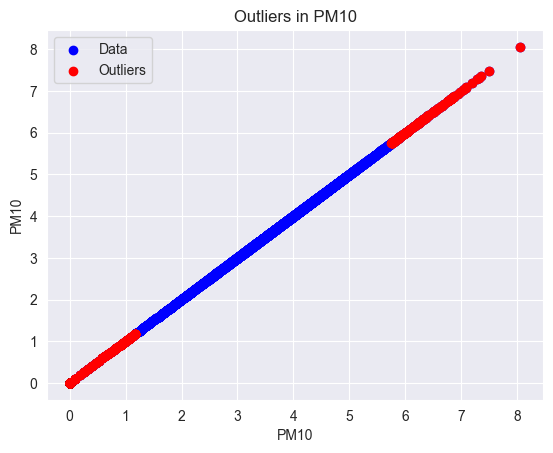

In [25]:
create_outlier_scatter_plots(modified_data_frame, AIR_QUALITY_WEATHER_COLUMNS, FIGURES_PATH)

In [26]:
def time_series_plot(data_frame: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.plot(data_frame['Date'], data_frame['Temp'])
    plt.title('Temperature Over Time')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.savefig(f"{FIGURES_PATH}/time_series_plot.png")
    plt.show()

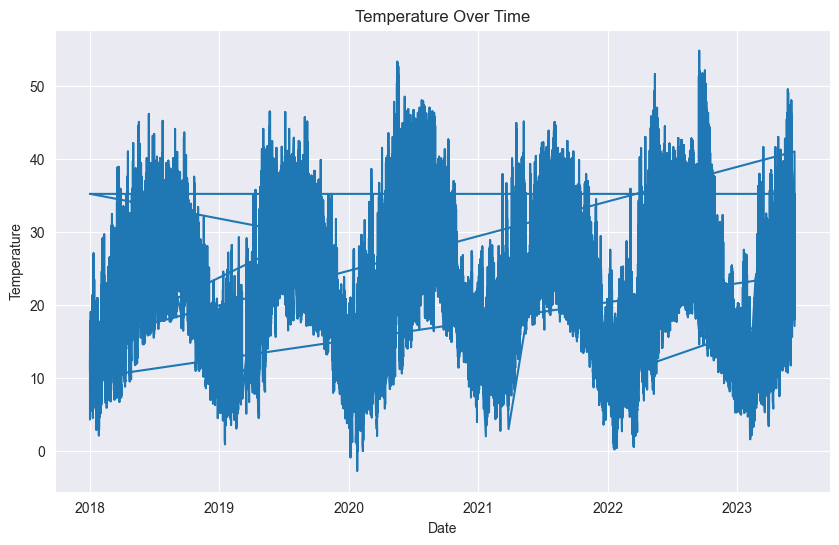

In [27]:
time_series_plot(modified_data_frame)

In [59]:
def histogram(data_frame: pd.DataFrame, x_column: str):
    plt.figure(figsize=(10, 6))
    data_frame[x_column].hist(bins=30)
    plt.title(f"{x_column} Distribution")
    plt.ylabel('Frequency')
    plt.xlabel(x_column)
    plt.savefig(f"{FIGURES_PATH}/histogram_{x_column}.png")
    plt.show()

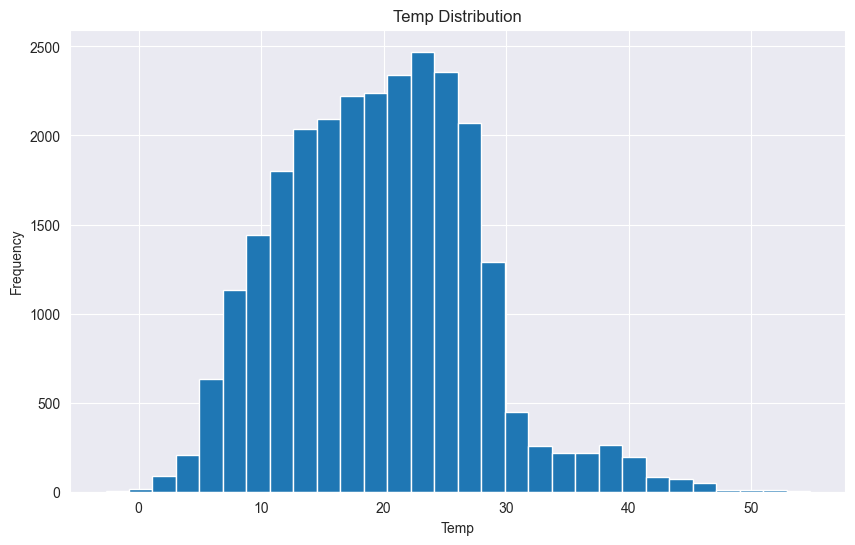

In [60]:
histogram(modified_data_frame, 'Temp')

In [30]:
def heatmap(data_frame: pd.DataFrame):
    correlation_matrix = data_frame.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.savefig(f"{FIGURES_PATH}/Correlation Heatmap.png")
    plt.show()

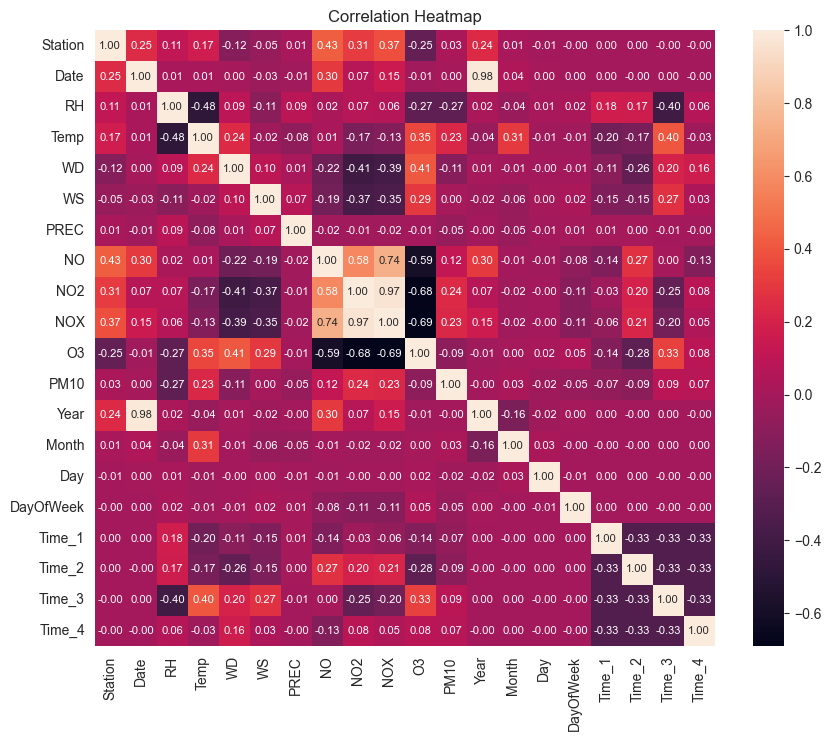

In [31]:
heatmap(modified_data_frame)

In [34]:
def boxplot(data_frame: pd.DataFrame, column: str):
    plt.figure(figsize=(10, 6))
    data_frame.boxplot(column=column)
    plt.title(f"{column} Boxplot")
    plt.savefig(f"{FIGURES_PATH}/boxplot_{column}.png")
    plt.show()

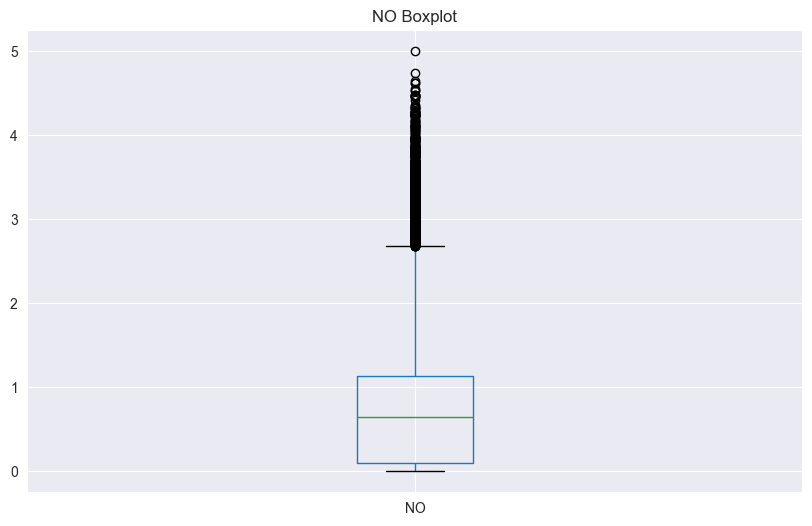

In [66]:
boxplot(modified_data_frame, 'NO')

In [63]:
def relationship_scatter_plot(data_frame: pd.DataFrame, columns: tuple):
    if len(columns) != 2:
        return
    x_column = columns[0]
    y_column = columns[1]
    plt.figure(figsize=(10, 6))
    plt.scatter(data_frame[x_column], data_frame[y_column])
    plt.title(f"{x_column} vs {y_column}")
    plt.xlabel(f"{x_column}")
    plt.ylabel(f"{y_column}")
    plt.savefig(f"{FIGURES_PATH}/relationship_scatter_plot_{x_column}_{y_column}.png")
    plt.show()

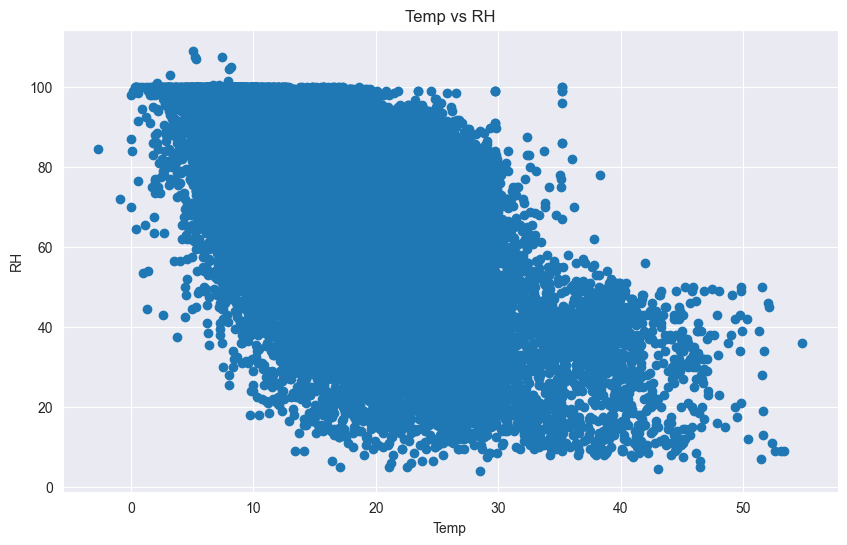

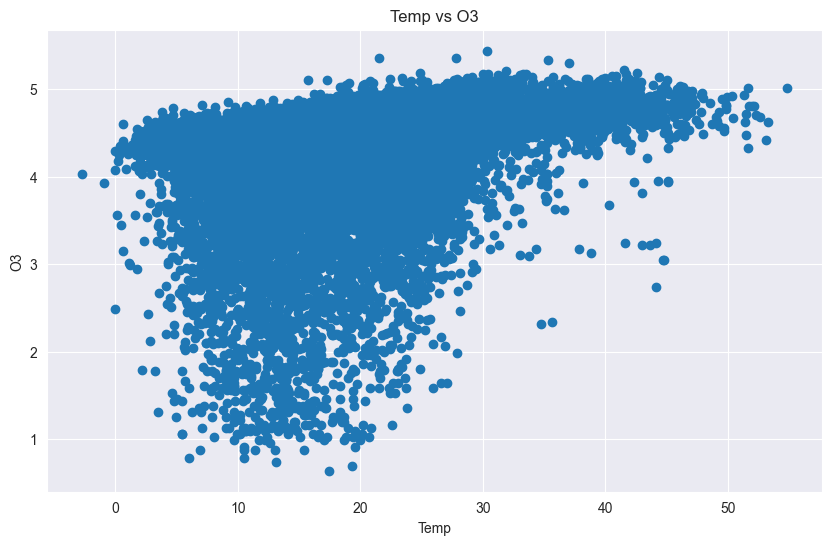

In [66]:
relationship_scatter_plot(modified_data_frame, (DF_COLUMNS.TEMP.value, DF_COLUMNS.RH.value))
relationship_scatter_plot(modified_data_frame, (DF_COLUMNS.TEMP.value, DF_COLUMNS.O3.value))

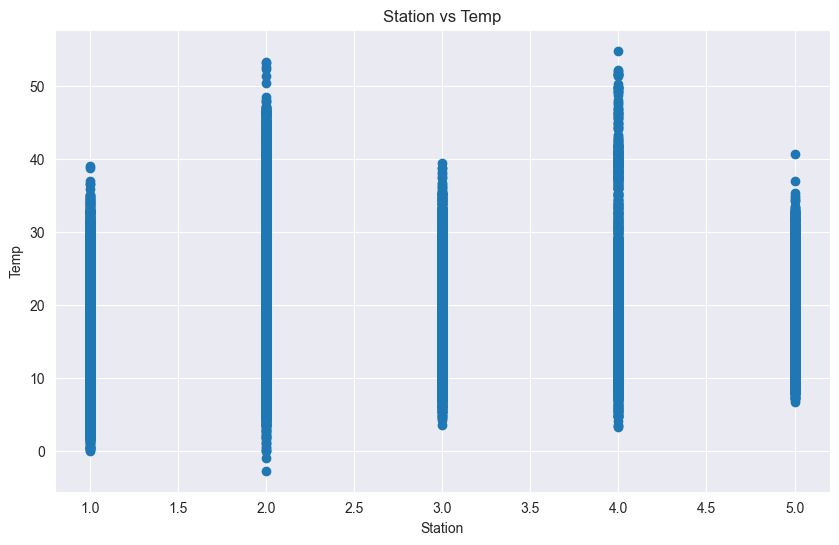

In [67]:
relationship_scatter_plot(modified_data_frame, (DF_COLUMNS.STATION.value, DF_COLUMNS.TEMP.value))

# Model Performance Evaluation

In this stage of the project, we focus on evaluating the performance of our machine learning models. This is an essential step as it gives us insights into the effectiveness of our models in accurately predicting air quality based on weather conditions.

## Models Used
For this project, we've chosen the following machine learning models due to their proven effectiveness in handling regression problems:

1. **Linear Regression:** Linear Regression model tries to draw a line that will best minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation.

2. **Decision Trees:** A Decision Tree is a flowchart-like tree structure where an internal node represents a feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome.

3. **Random Forest:** Random Forest is a powerful ensemble machine learning algorithm that builds on the Decision Tree model. It constructs a multitude of decision trees at training time and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

4. **Gradient Boosting:** Gradient Boosting is another ensemble machine learning algorithm that produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

5. **Lasso Regression:** Lasso Regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean.

6. **K-Nearest Neighbors (KNN):** K-Nearest Neighbors is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions).

7. **Neural Networks:** Neural networks are a set of algorithms, modeled loosely after the human brain, that are designed to recognize patterns.

## Evaluation Metrics

To evaluate the performance of these models, we use two key metrics:

1. **Mean Squared Error (MSE):** The MSE is the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. Lower values of MSE indicate a better fit to the data.

2. **R-Squared (R2 Score):** The R-squared (R2) statistic provides a measure of how well the model is fitting the actual data. It takes the form of a proportion—the proportion of variance explained—and so it always takes on a value between 0 and 1. In simple words, higher values indicate that more of the variance is captured by the model.

The function `calculate_mse_r2` calculates and logs the Mean Squared Error (MSE) and R2 Score of model predictions. These metrics help in understanding the performance of the predictive models.

- **Mean Squared Error (MSE):** This measures the average of the squares of the errors, indicating how close predictions are to the actual outcomes.
- **R2 Score:** Also known as the coefficient of determination, it represents the proportion of the variance in the dependent variable that is predictable from the independent variables. An R2 score close to 1 indicates a model that explains a large portion of the variance in the response variable.

The function logs these results, giving a clear indication of model performance. If the R2 score is below 0.6, it logs an error message to highlight this.

In [60]:
def calculate_mse_r2(y_test, predictions, model_name):
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Print results
    logger.log_separator_line(logger.LOG_LINE_SEPERATOR_LENGTH, f"Calculate MSE & R2 score")
    logger.log(f'{model_name} Results:')
    r2_msg_level = logger.ERROR if r2 < 0.6 else logger.INFO
    logger.log(f"Mean Squared Error: {mse}")
    logger.log(f"R2 Score: {r2}", r2_msg_level)
    logger.log_separator_line(logger.LOG_LINE_SEPERATOR_LENGTH)

## Model Training and Evaluation

The function `test_models` is responsible for splitting the data into training and testing sets, training the models on the training data, and evaluating their performance on the testing data. The function also logs the feature importance if it's applicable for the used model.

Currently, the models included are `RandomForestRegressor` and `MultiOutputRegressor` with `GradientBoostingRegressor`. For each model:

1. The model is fitted using the training data.
2. If the model has feature importance, it logs the importance of each feature.
3. The model's predictions on the test set are made.
4. The Mean Squared Error (MSE) and R2 Score are calculated for these predictions using `calculate_mse_r2`.

In [61]:
def test_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # List of models to evaluate
    decisiontree_parameters = {'max_depth': range(1,10), 'min_samples_split': range(10,60,10), 'min_samples_leaf': range(1,5)}
    lasso_parameters = {'alpha': [1e-4, 1e-3, 1e-2, 1, 10, 100]}
    knn_parameters = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
    mlp_parameters = {'hidden_layer_sizes': [(50,), (100,), (50,50)], 'activation': ['relu', 'logistic']}
    models = [
        # ('Lasso', GridSearchCV(Lasso(random_state=42), lasso_parameters, scoring='neg_mean_squared_error', cv=5)),
        # ('KNN', GridSearchCV(KNeighborsRegressor(), knn_parameters, scoring='neg_mean_squared_error', cv=5)),
        # ('Neural Network', GridSearchCV(MLPRegressor(random_state=42), mlp_parameters, scoring='neg_mean_squared_error', cv=5))
        ('DecisionTree', GridSearchCV(DecisionTreeRegressor(random_state=42), decisiontree_parameters,  scoring='neg_mean_squared_error', cv=5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('GradientBoosting', MultiOutputRegressor(GradientBoostingRegressor(random_state=42))),
    ]

# Iterate over the models and print results
    column_names = X.columns
    for model_name, model in models:
        # Fit the model
        logger.log(f"Mode Name: {model_name}")
        model.fit(X_train, y_train)

        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            # summarize feature importance
            logger.log(f"Feature scores:")
            for i, j in enumerate(importance):
                logger.log(f"{column_names[i]}: {'{:.1f}'.format(j)}%")
        # Make predictions
        predictions = model.predict(X_test)
        calculate_mse_r2(y_test, predictions, model_name)

## Feature and Target Variables Selection

The block of code selects the features (`X`) and the target (`y`) variables from the previously cleaned and transformed DataFrame.

For features (`X`), the selected columns include station ID, components of the date (_year, month, day,_ and _day of the week_), binary representations of the time, and weather parameters (_relative humidity, temperature, wind direction, wind speed,_ and _precipitation_).

The target variables (`y`) are the concentrations of the various air pollutants (_NO, NO2, NOx,_ and _O3_).

In [62]:
feature_columns = [
    DF_COLUMNS.STATION.value,
    ADDED_COLUMNS.YEAR, ADDED_COLUMNS.MONTH,
    ADDED_COLUMNS.DAY_OF_WEEK,
    ADDED_COLUMNS.TIME_1, ADDED_COLUMNS.TIME_2, ADDED_COLUMNS.TIME_3, ADDED_COLUMNS.TIME_4,
    # ADDED_COLUMNS.DAY,
    DF_COLUMNS.TEMP.value,
    DF_COLUMNS.RH.value,
    DF_COLUMNS.WD.value,
    DF_COLUMNS.WS.value,
    DF_COLUMNS.PREC.value,
]
target_columns = [
    # f"{DF_COLUMNS.NO.value}_Group",
    # f"{DF_COLUMNS.NO2.value}_Group",
    # f"{DF_COLUMNS.NOX.value}_Group",
    # f"{DF_COLUMNS.O3.value}_Group",
    # f"{DF_COLUMNS.PM10.value}_Group"
    DF_COLUMNS.O3.value,
    DF_COLUMNS.NO.value,
    DF_COLUMNS.NO2.value,
    DF_COLUMNS.NOX.value,
    # DF_COLUMNS.PM10.value,
]
X = modified_data_frame[feature_columns]
y = modified_data_frame[target_columns]

In [63]:
test_models(X, y)

Mode Name: DecisionTree
--------Calculate MSE & R2 score--------
DecisionTree Results:
Mean Squared Error: 0.2237481870338156
R2 Score: 0.6048830701230218
----------------------------------------
Mode Name: RandomForest
Feature scores:
Station: 0.2%
Year: 0.1%
Month: 0.0%
DayOfWeek: 0.1%
Time_1: 0.0%
Time_2: 0.0%
Time_3: 0.0%
Time_4: 0.0%
Temp: 0.1%
RH: 0.1%
WD: 0.3%
WS: 0.1%
PREC: 0.0%
--------Calculate MSE & R2 score--------
RandomForest Results:
Mean Squared Error: 0.16263367849341004
R2 Score: 0.7126517450639897
----------------------------------------
Mode Name: GradientBoosting
--------Calculate MSE & R2 score--------
GradientBoosting Results:
Mean Squared Error: 0.2032154427923203
R2 Score: 0.6419448019871549
----------------------------------------
